# RIO- 125 Classification Model - Build a Model that Classifies the Side Effects of a Drug

# Life cycle of data analysis projects
1.Data Analysis

2.Feature Engineering

3.Feature Selection

4.Model Building

5.Model Deployment

In [1]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade spacy

In [3]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 12.8/12.8 MB 3.7 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import numpy as np
import pandas as pd
from random import choice, sample
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

import itertools
import math
import re
import string
import spacy
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from nltk.corpus import stopwords


from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Loading Dataset

In [5]:
data = pd.read_csv(r"C:\Users\susha\Downloads\webmd.csv")

# Data Understanding

In [6]:
data.shape

(362806, 12)

In [7]:
data.head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362806 entries, 0 to 362805
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Age            362806 non-null  object
 1   Condition      362806 non-null  object
 2   Date           362806 non-null  object
 3   Drug           362806 non-null  object
 4   DrugId         362806 non-null  int64 
 5   EaseofUse      362806 non-null  int64 
 6   Effectiveness  362806 non-null  int64 
 7   Reviews        362769 non-null  object
 8   Satisfaction   362806 non-null  int64 
 9   Sex            362806 non-null  object
 10  Sides          362806 non-null  object
 11  UsefulCount    362806 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 33.2+ MB


In [9]:
data.describe()

,DrugId,EaseofUse,Effectiveness,Satisfaction,UsefulCount
count,362806.000000,362806.000000,362806.000000,362806.000000,362806.000000
mean,36879.370774,4.019829,3.532061,3.135408,6.744916
std,52624.412971,1.317711,1.455961,1.611106,9.324240
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,4896.000000,3.000000,3.000000,1.000000,1.000000
50%,9548.000000,5.000000,4.000000,3.000000,4.000000
75%,63522.000000,5.000000,5.000000,5.000000,9.000000
max,178546.000000,10.000000,10.000000,10.000000,255.000000


#### Description of the dataset
Name : Name of the patient

Race : Race of the patient

Age : Age of the patient

Condition : Condition/symptom from which the patient is suffering

Date : Date of usage

Drug : Name of the drug

DrugId : Identity/code of drug

EaseofUse : Patient's 10-Star rating on the ease of use of drug

Effectiveness : Patient's 10-Star rating on the effectiveness of drug

Reviews : Patient's review

Satisfaction : Patient's 10-Star rating on satisfaction

Sex : Gender of the patient

Sides : Side effects of the drug

UsefulCount : Number of users who found the review useful

# Add names and races columns

In [10]:
pip install mimesis

Note: you may need to restart the kernel to use updated packages.


In [11]:
from mimesis import Person
person = Person('en')

# function to create names to exact rows
def fake_names(n):
   name = []
   for _ in range(0, n):
        name.append(person.name())
   return name

names = fake_names(362806)

data_name = pd.DataFrame(list(zip(names)),columns = ['Name'])

data_name.head()

,Name
0,Vertie
1,Tonita
2,Dorla
3,Carmen
4,Xenia


In [12]:
import random

options = [("White", 0.32), ("Hispanic", 0.28), ("Black", 0.22), ("Asian", 0.18)]
words = []

for i in range(362806):
    word = random.choices([o[0] for o in options], [o[1] for o in options])[0]
    words.append(word)

data_race=pd.DataFrame(words, columns = ['Race'])

data_race.head()

,Race
0,White
1,Hispanic
2,Hispanic
3,Black
4,White


In [13]:
data1 = pd.concat([data_name, data_race, data], axis=1).reindex(data.index)
data1.head()

,Name,Race,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,Vertie,White,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,Tonita,Hispanic,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,Dorla,Hispanic,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,Carmen,Black,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,Xenia,White,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


In [14]:
# Rename the column sides
data1 = data1.rename(columns={'Sides':'SideEffects'})

In [15]:
data1['Year'] = pd.to_datetime(data1['Date'], errors='coerce').dt.year
data1['Month'] = pd.to_datetime(data1['Date'], errors='coerce').dt.month
data1['day_of_week'] = pd.to_datetime(data1['Date'], errors='coerce').dt.day_name()

dataset is ready for EDA and preprocessing

In [16]:
data1.Sex.value_counts()

Female    238226
Male       98043
           26537
Name: Sex, dtype: int64

In [17]:
data.Drug.value_counts()

cymbalta                               4648
lisinopril                             4269
lisinopril solution                    4269
lexapro                                4134
hydrocodone-acetaminophen              3944
                                       ... 
sorbsan bandage                           1
sorbsan topical wound dressing 3" x       1
q-pap extra strength                      1
symax                                     1
vanadium granules                         1
Name: Drug, Length: 7093, dtype: int64

In [18]:
data1.SideEffects.value_counts()

                                                                                                                                                       17460
Nausea ,  vomiting ,  constipation ,  lightheadedness ,  dizziness , or drowsiness may occur.                                                          15563
Nausea ,  vomiting ,  headache ,  bloating ,  breast  tenderness, swelling of the  ankles /feet (fluid retention), or  weight  change may occur.       12116
Dizziness ,  lightheadedness , tiredness, or  headache  may occur as your body adjusts to the  medication . Dry  cough  may also occur.                 9162
Drowsiness,  dizziness , loss of coordination, tiredness, blurred/ double vision , unusual  eye  movements, or shaking (tremor) may occur.              7790
                                                                                                                                                       ...  
Nausea ,  vomiting ,  stomach / abdominal pain , gas,  dia

In [19]:
data1.Age.value_counts()

45-54         80043
55-64         75136
35-44         55011
25-34         49718
65-74         41216
19-24         24230
75 or over    15226
              12202
13-18          7045
7-12           1644
3-6             838
0-2             497
Name: Age, dtype: int64

In [20]:
data1.Satisfaction.value_counts()

5     111550
1     100901
4      63158
3      51852
2      35342
6          2
10         1
Name: Satisfaction, dtype: int64

In [21]:
# Creating a list of numerical values

numerical_features = [feature for feature in data1.columns if data1[feature].dtypes != 'O']

print("The length of numerical variables: " ,len(numerical_features),'\n')

#display the numerical variables

data1[numerical_features].head()

The length of numerical variables:  7 



,DrugId,EaseofUse,Effectiveness,Satisfaction,UsefulCount,Year,Month
0,146724,5,5,5,0,2014,9
1,146724,5,5,5,1,2011,1
2,144731,2,3,3,0,2012,7
3,144731,2,2,1,0,2010,9
4,144731,1,1,1,1,2009,1


In [22]:
#Numerical Variables are usually of two types - Continuous and discrete

discrete_feature = [feature for feature in numerical_features if len(data1[feature].unique())<25]  # Simply consider values below 25 as discrete

print("Discrete Variables Count: {}".format(len(discrete_feature)))
print('Discrete variables are ',discrete_feature)

Discrete Variables Count: 5
Discrete variables are  ['EaseofUse', 'Effectiveness', 'Satisfaction', 'Year', 'Month']


In [23]:
continuous_feature = [feature for feature in numerical_features if feature not in discrete_feature]
print("Continuous feature Count {}".format(len(continuous_feature)))
print('Continuous variables are ', continuous_feature)

Continuous feature Count 2
Continuous variables are  ['DrugId', 'UsefulCount']


In [24]:
categorical_features = [feature for feature in data1.columns if data1[feature].dtypes=='O']
print("Categorical feature Count {}".format(len(categorical_features)))
print('Categorical variables are ', categorical_features)

Categorical feature Count 10
Categorical variables are  ['Name', 'Race', 'Age', 'Condition', 'Date', 'Drug', 'Reviews', 'Sex', 'SideEffects', 'day_of_week']


In [25]:
#Checking Cardinality

for feature in categorical_features:
    print("The feature is {} and number of labels are {}".format(feature,len(data1[feature].unique())))

The feature is Name and number of labels are 3323
The feature is Race and number of labels are 4
The feature is Age and number of labels are 12
The feature is Condition and number of labels are 1806
The feature is Date and number of labels are 4524
The feature is Drug and number of labels are 7093
The feature is Reviews and number of labels are 250168
The feature is Sex and number of labels are 3
The feature is SideEffects and number of labels are 1651
The feature is day_of_week and number of labels are 7


# **BIVARIATE ANALYSIS**

**Bar Plot**

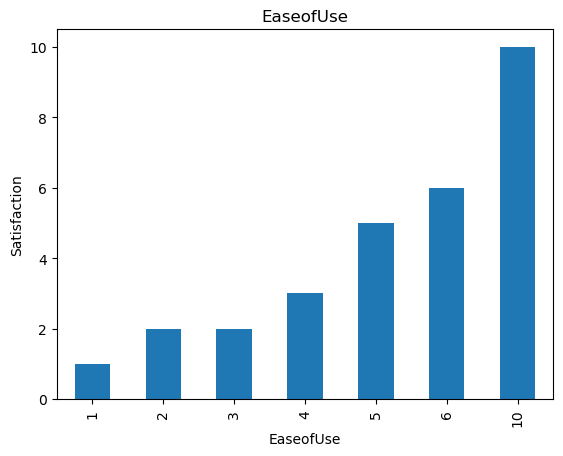

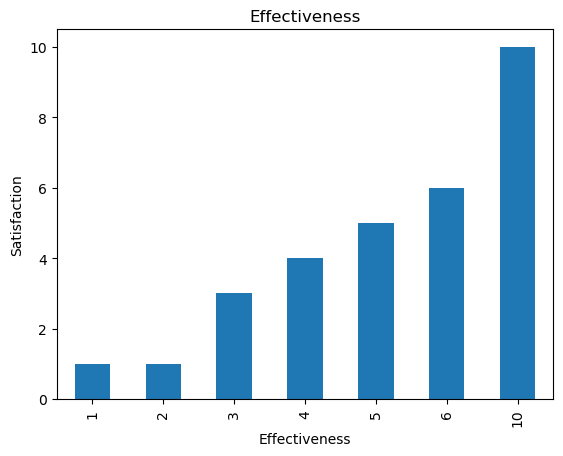

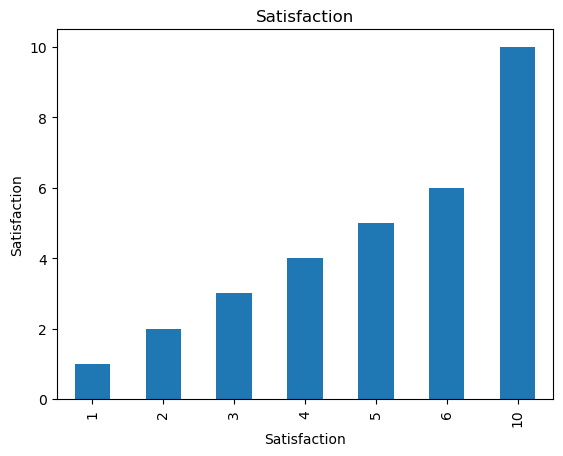

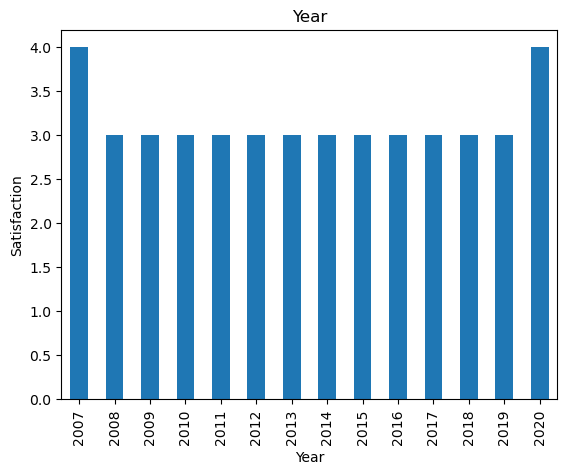

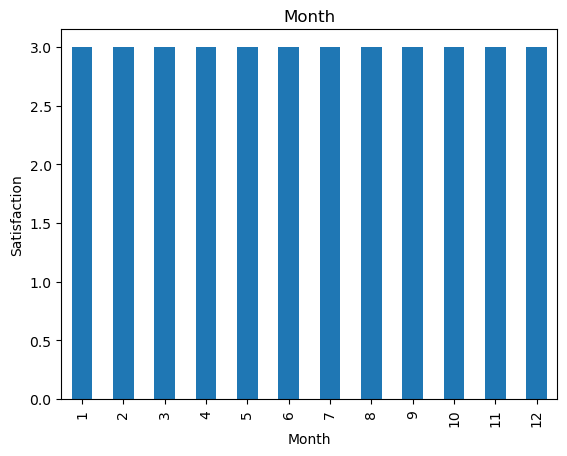

In [26]:
#Finding Relationship with Discrete features and Satisfaction

for feature in discrete_feature:
    df = data1.copy()
    df.groupby(feature)['Satisfaction'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Satisfaction')
    plt.title(feature)
    plt.show()

From the graph it is evident that as the Ease of use and Effectiveness increased the satisfaction levels also increased.

**UNIVARIATE ANALYSIS**

**Histogram**

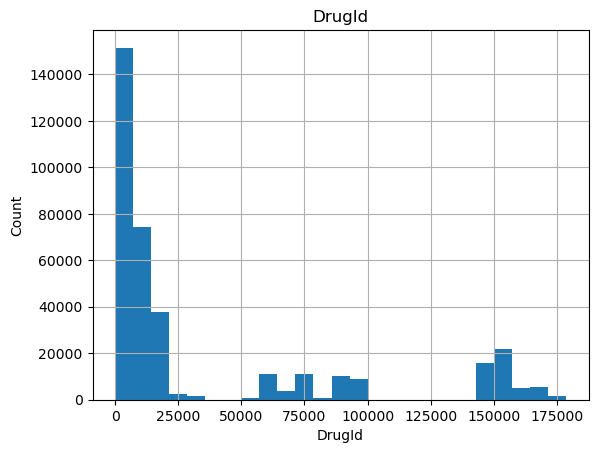

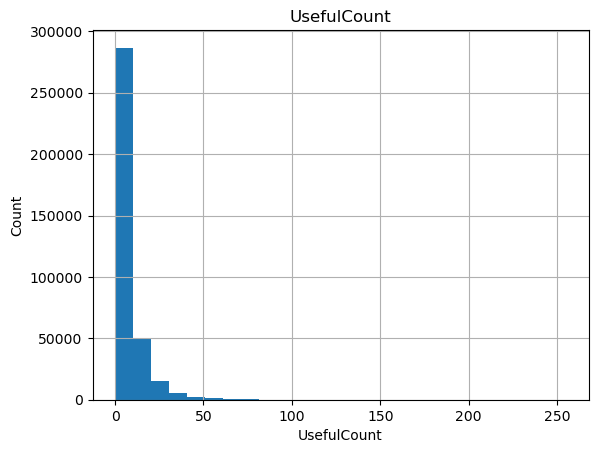

In [27]:
#Analyzing the Distribution of Continuous variables

for feature in continuous_feature:
    df = data1.copy()
    df[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

The histogram shows that the data distribution is skewed.

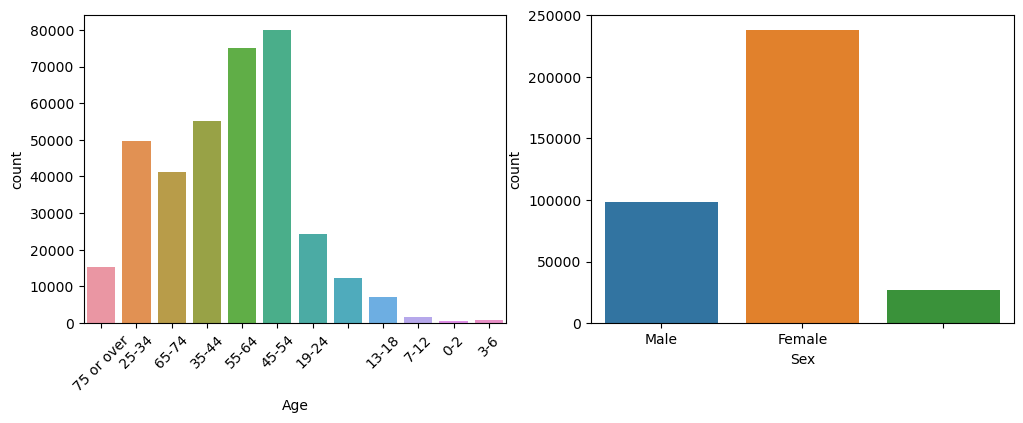

In [28]:
# Bar Charts of some categorical columns

plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.countplot(data=data1, x='Age')
plt.xticks(rotation=45)
plt.subplot(122)
sns.countplot(data=data1, x='Sex')
plt.show()

From the graph it is evident that females users are more than male users. And the age age group of 45-54 are predominant users than other age group.

# Top 20 Drugs based on No. of Users

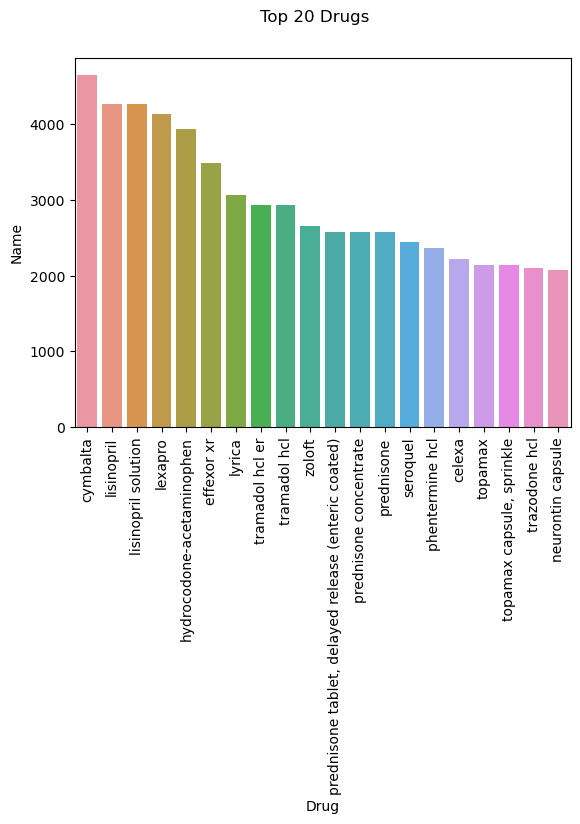

In [29]:
data_= data1['Drug'].value_counts().head(20).reset_index()
data_.columns = ['Drug', 'Name']
sns.barplot(data=data_, x = 'Drug', y = 'Name')
plt.suptitle("Top 20 Drugs")
plt.xticks(rotation=90,fontsize=10)
plt.show()

So the most commmonly used drug is cymbalta followed by lisinopril. All these 20 druge were used by more than 2000 people.

# Top 15 Conditions

Text(0, 0.5, 'Users')

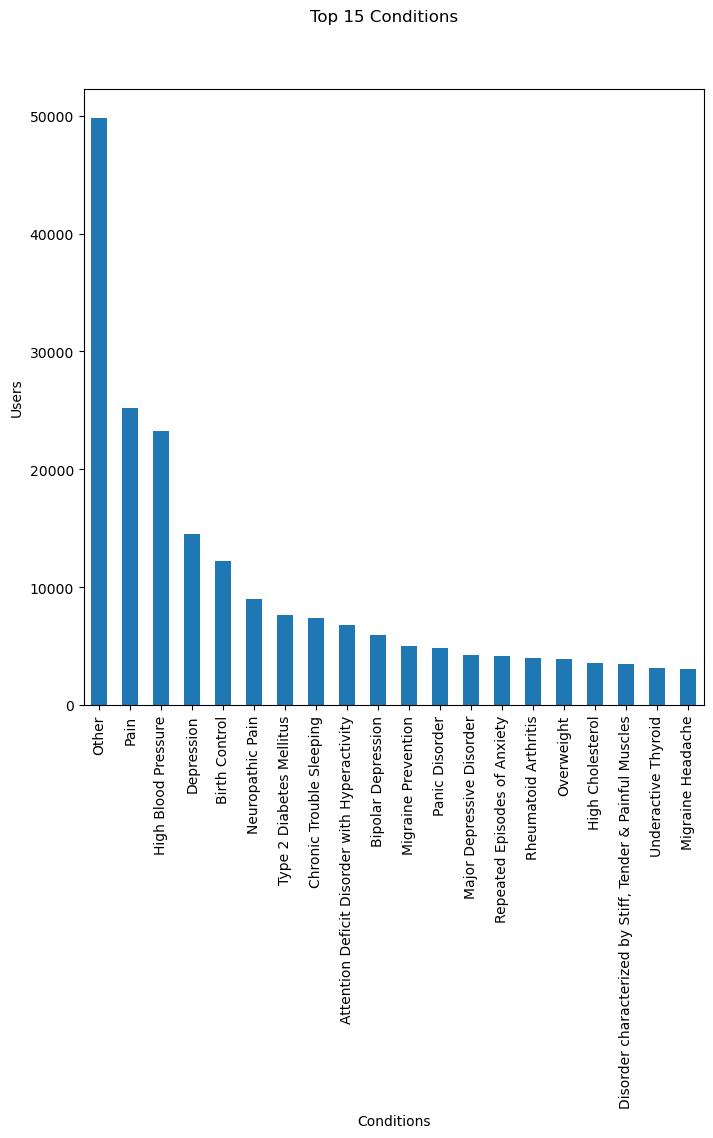

In [30]:
data['Condition'].value_counts().nlargest(20).plot(kind='bar',figsize=(8,8))
plt.suptitle("Top 15 Conditions")
plt.xlabel('Conditions')
plt.ylabel('Users')

#### As much as 50,000 users have reported other conditions followed by Pain topped the list with more than 25000 people reporting it.

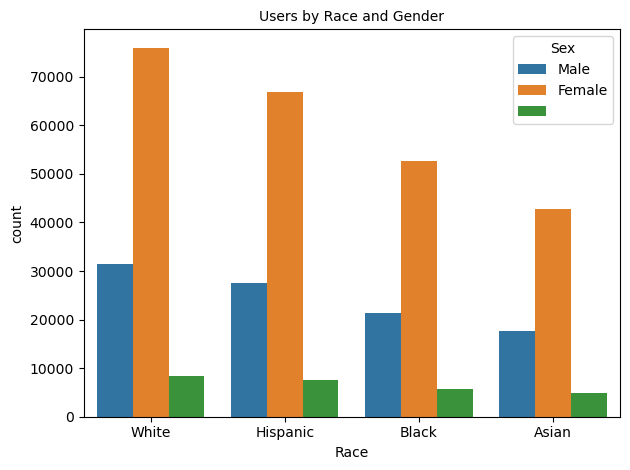

In [31]:
sns.countplot(x='Race',hue='Sex',data=data1)
plt.title("Users by Race and Gender", fontsize = 10)
plt.tight_layout()
plt.show()

In all the races females are using drugs more than males and others.

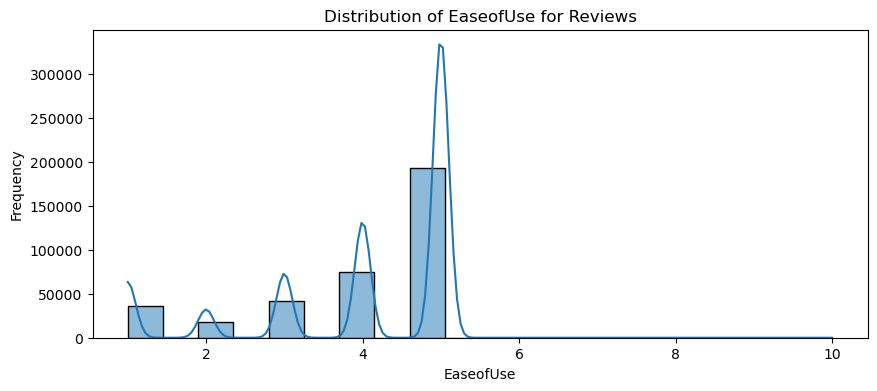

Mean EaseofUse: 4.02
Median EaseofUse: 5.00
Standard Deviation EaseofUse: 1.32


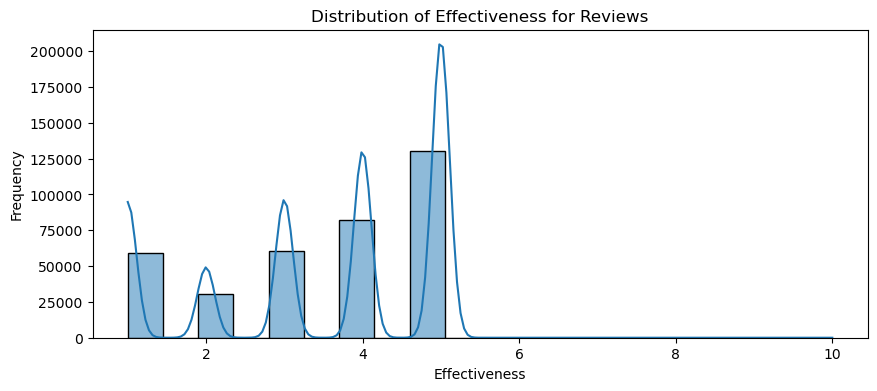

Mean Effectiveness: 3.53
Median Effectiveness: 4.00
Standard Deviation Effectiveness: 1.46


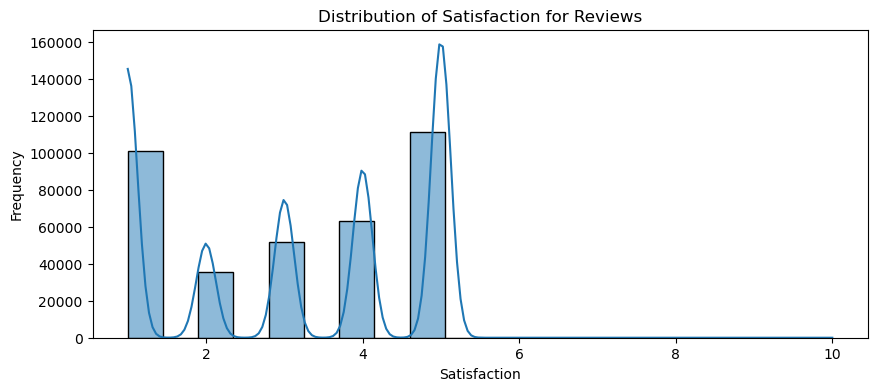

Mean Satisfaction: 3.14
Median Satisfaction: 3.00
Standard Deviation Satisfaction: 1.61


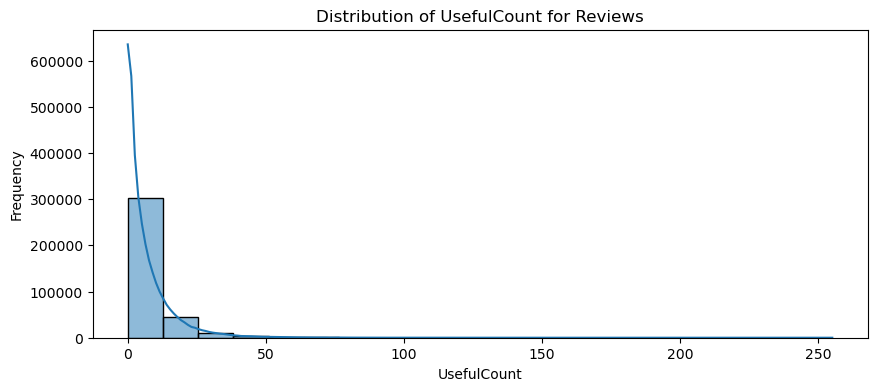

Mean UsefulCount: 6.74
Median UsefulCount: 4.00
Standard Deviation UsefulCount: 9.32


In [32]:
feature = ['EaseofUse','Effectiveness',  'Satisfaction','UsefulCount']

for i in feature:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=data1, x= i, bins=20, kde=True)
    plt.title(f'Distribution of {i} for Reviews')
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.show()
# Compute statistics for the current feature
    feature_mean = data1[i].mean()
    feature_median = data1[i].median()
    feature_std = data1[i].std()
    print(f"Mean {i}: {feature_mean:.2f}")
    print(f"Median {i}: {feature_median:.2f}")
    print(f"Standard Deviation {i}: {feature_std:.2f}")

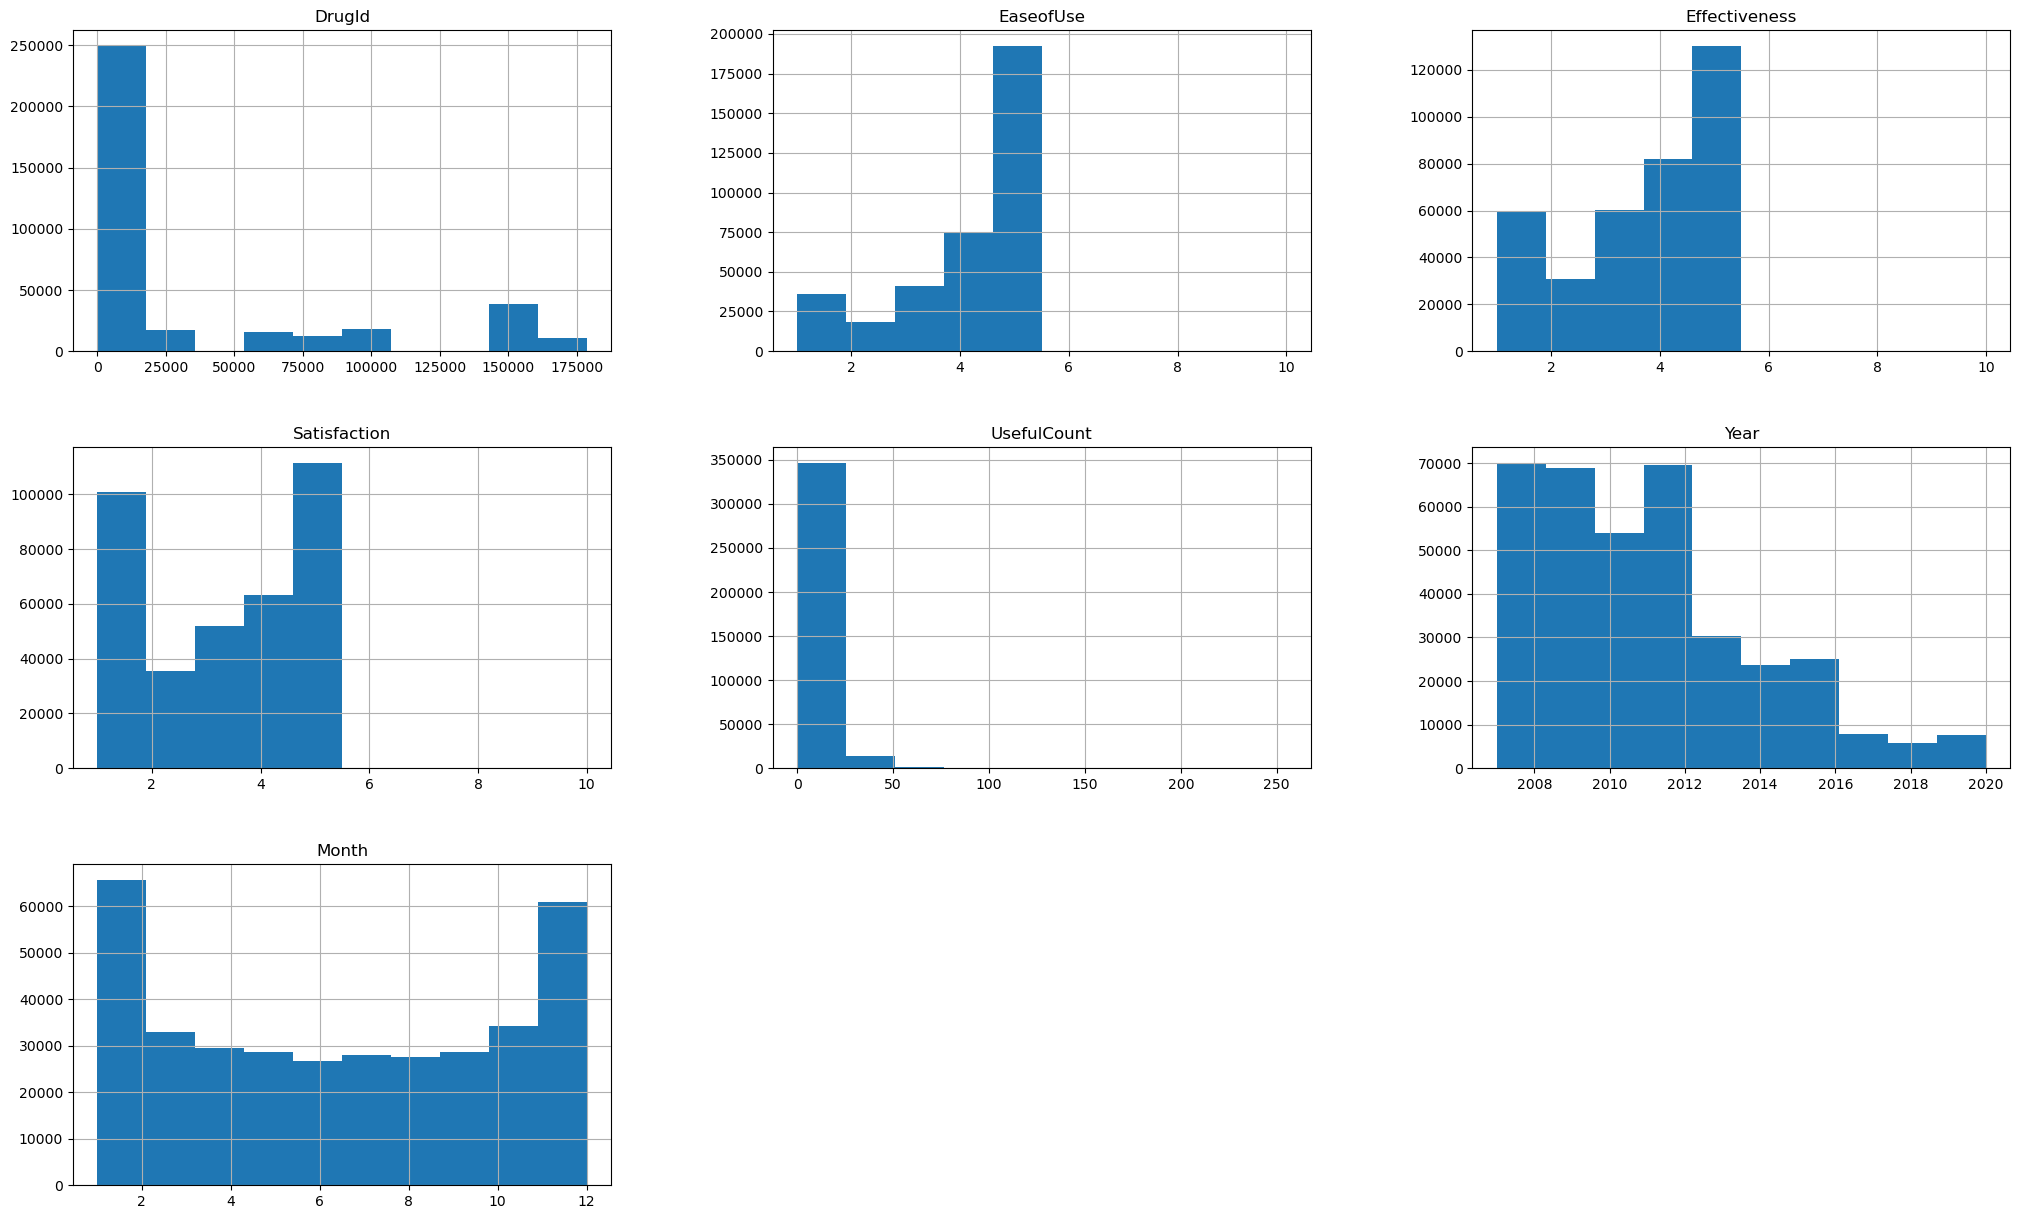

In [33]:
#plot graphs for float and int data types
freqgraph = data1.select_dtypes(include=['int'])
freqgraph.hist(figsize=(25,15))
plt.show()

<Figure size 1000x800 with 0 Axes>

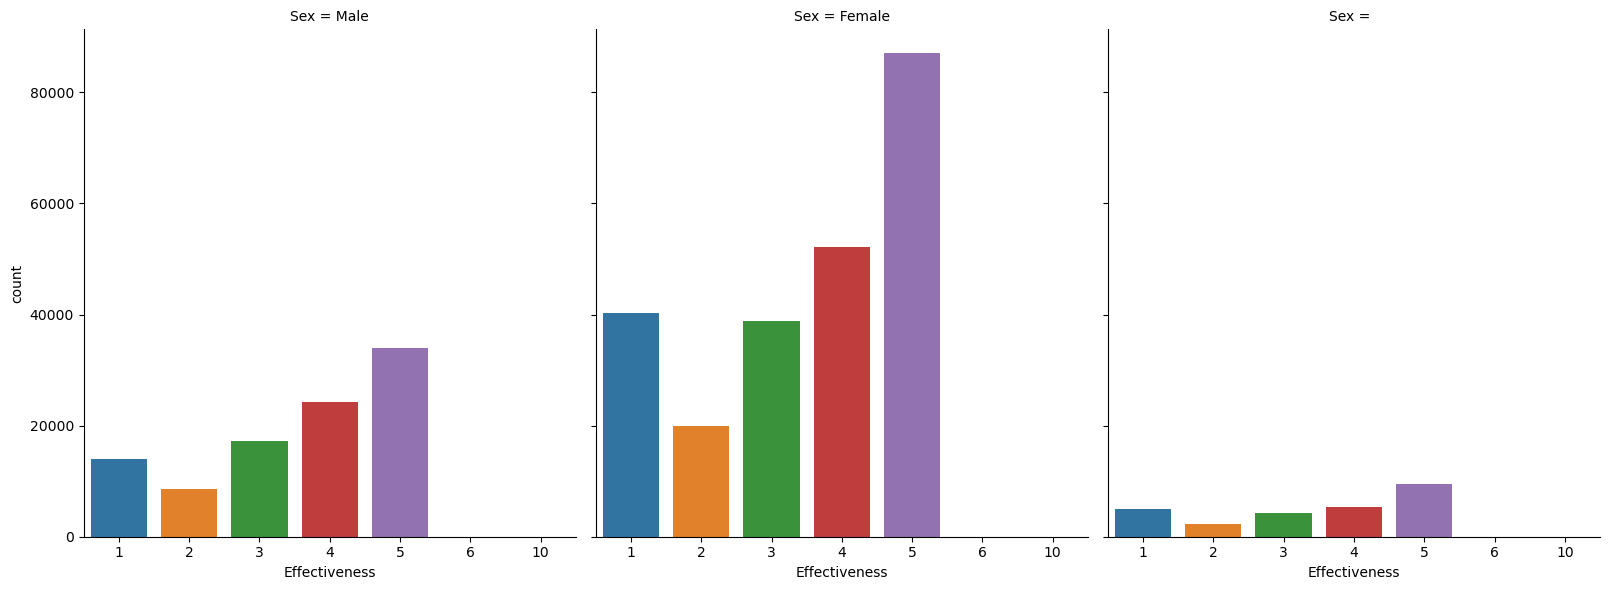

In [34]:
plt.figure(figsize=(10,8))
g = sns.catplot(x="Effectiveness",col="Sex",
                data=data1, kind="count",
                height=6,aspect =.9);

In females efffectiveness of 5 was observed for more than 60000 users.

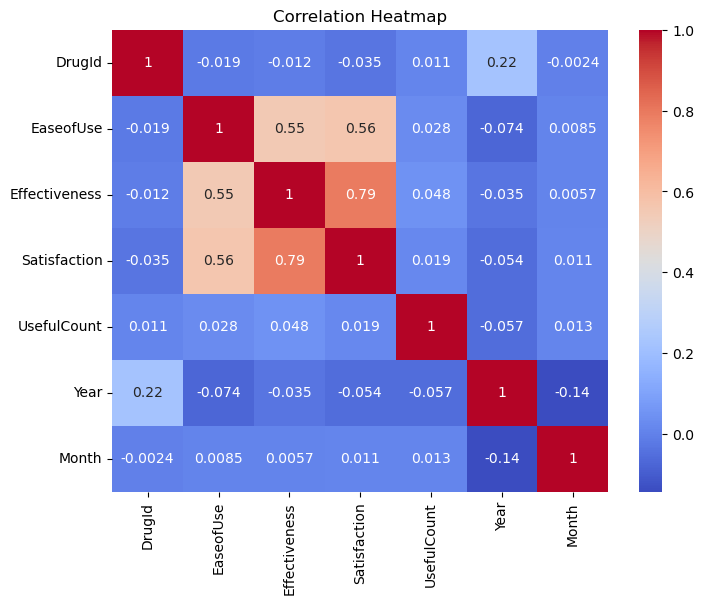

In [35]:
# Correlation heatmap
corr_matrix = data1.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

From the heatmap a positive correlation is found between EaseofUse and effectiveness, Effectiveness and satisfaction and ease of use and satisfaction

# Preprocessing

In [36]:
# Check for missing values:

data1.isna().sum()

Name              0
Race              0
Age               0
Condition         0
Date              0
Drug              0
DrugId            0
EaseofUse         0
Effectiveness     0
Reviews          37
Satisfaction      0
Sex               0
SideEffects       0
UsefulCount       0
Year              0
Month             0
day_of_week       0
dtype: int64

In [37]:
# Nan rows were dropped
data1.dropna(axis = 0, inplace = True)
data1.isna().sum()

Name             0
Race             0
Age              0
Condition        0
Date             0
Drug             0
DrugId           0
EaseofUse        0
Effectiveness    0
Reviews          0
Satisfaction     0
Sex              0
SideEffects      0
UsefulCount      0
Year             0
Month            0
day_of_week      0
dtype: int64

In [38]:
# Handling instances with whitespaces
for i in data1:
    data1[i]=np.where(data1[i]==" ",np.NAN,data1[i])
    
data1.isna().sum()

Name                 0
Race                 0
Age              12199
Condition           43
Date                 0
Drug                 0
DrugId               0
EaseofUse            0
Effectiveness        0
Reviews          41824
Satisfaction         0
Sex              26533
SideEffects      17454
UsefulCount          0
Year                 0
Month                0
day_of_week          0
dtype: int64

In [39]:
data1.dropna(axis=0, inplace = True)
data1.isna().sum()

Name             0
Race             0
Age              0
Condition        0
Date             0
Drug             0
DrugId           0
EaseofUse        0
Effectiveness    0
Reviews          0
Satisfaction     0
Sex              0
SideEffects      0
UsefulCount      0
Year             0
Month            0
day_of_week      0
dtype: int64

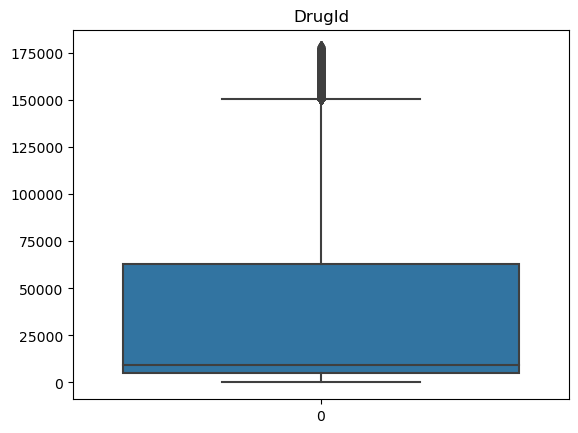

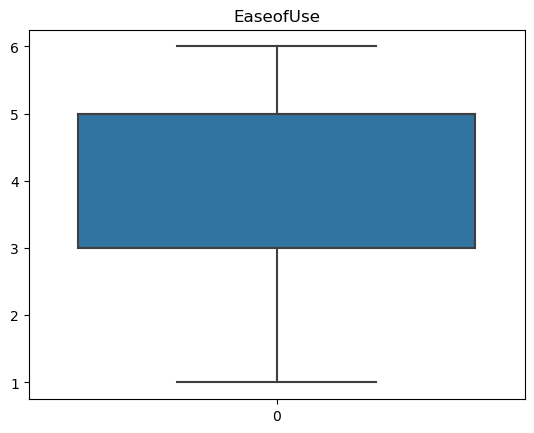

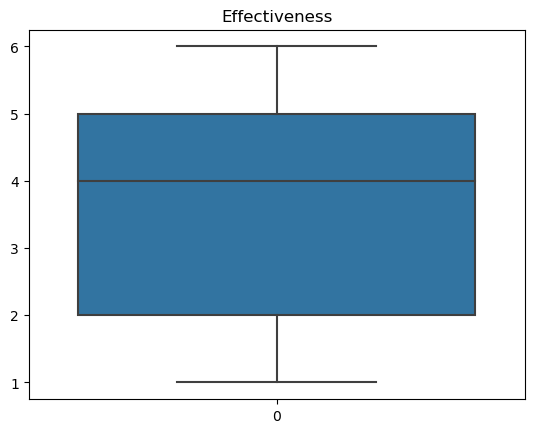

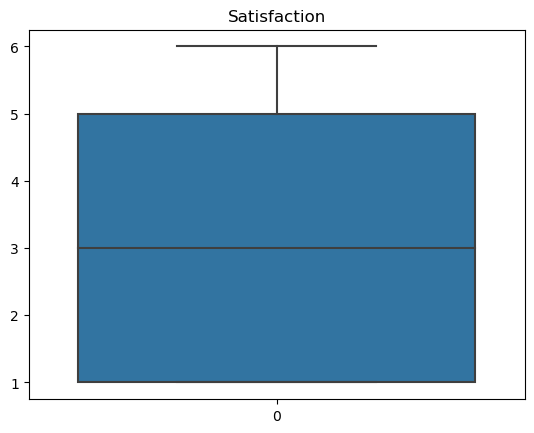

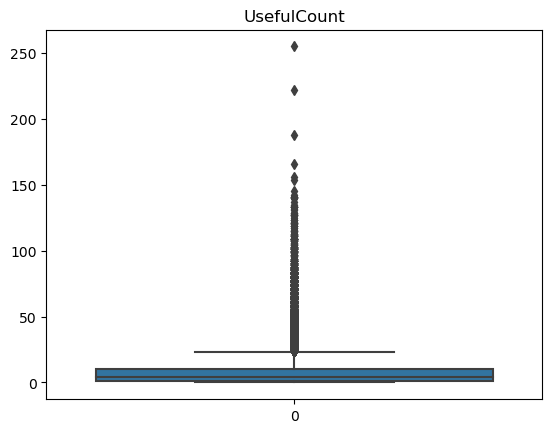

In [40]:
#create a boxplot to display outlier


num_cols = ['DrugId', 'EaseofUse',
       'Effectiveness','Satisfaction','UsefulCount']
for i in num_cols:
    plt.figure()
    sns.boxplot(data1[i])
    plt.title(i)

Drug Id and Useful count column have outliers

In [41]:
# Calculate the quartiles Q1, Q2 (median), and Q3 of the 'DrugId' column :

Q1 = np.percentile(data1['DrugId'],25,interpolation='midpoint')
Q2 = np.percentile(data1['DrugId'],50,interpolation='midpoint')
Q3 = np.percentile(data1['DrugId'],75,interpolation='midpoint')


#print the quartiles

print('Q1 =', Q1)
print('Q2 =', Q2)
print('Q3 =', Q3)

# Calculate the interquartile range (IQR):

IQR = Q3 - Q1

#print iqr

print('IQR =',IQR)

# Define the upper and lower limits for outliers:

up_lim = Q3 + 1.5*IQR
low_lim = Q1 - 1.5*IQR

print ('up_lim = ', up_lim)
print ('low_lim = ', low_lim)


Q1 = 4896.0
Q2 = 9548.0
Q3 = 63163.0
IQR = 58267.0
up_lim =  150563.5
low_lim =  -82504.5


In [42]:
outliers = []

for x in data1 ['DrugId'] :
    if (x>up_lim) or (x<low_lim) :
        outliers.append(x)
print(outliers)

[163180.0, 163180.0, 164750.0, 164750.0, 164750.0, 164750.0, 164750.0, 164750.0, 164750.0, 164750.0, 164750.0, 164750.0, 164750.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 167493.0, 167493.0, 167493.0, 167493.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0,

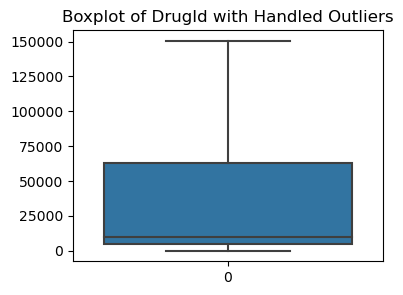

In [43]:
# Handle the outliers in the 'DrugId' column of the dataset by using flooring and capping:

data1['DrugId'] = np.where(data1['DrugId'] > up_lim, up_lim, np.where(data1['DrugId']<low_lim,low_lim,data1['DrugId']))
                                                                                                             
                                                                                                             
 # Again check for outliers after filling:

plt.figure(figsize=(4, 3))
sns.boxplot(data1['DrugId'])
plt.title('Boxplot of DrugId with Handled Outliers')
plt.show()

In [44]:
# Calculate the quartiles Q1, Q2 (median), and Q3 of the 'EaseofUse' column :

Q1 = np.percentile(data1['UsefulCount'],25,interpolation='midpoint')
Q2 = np.percentile(data1['UsefulCount'],50,interpolation='midpoint')
Q3 = np.percentile(data1['UsefulCount'],75,interpolation='midpoint')


#print the quartiles

print('Q1 =', Q1)
print('Q2 =', Q2)
print('Q3 =', Q3)

# Calculate the interquartile range (IQR):

IQR = Q3 - Q1



#print iqr

print('IQR =',IQR)

# Define the upper and lower limits for outliers:

up_lim = Q3 + 1.5*IQR
low_lim = Q1 - 1.5*IQR

print ('up_lim = ', up_lim)
print ('low_lim = ', low_lim)





Q1 = 1.0
Q2 = 4.0
Q3 = 10.0
IQR = 9.0
up_lim =  23.5
low_lim =  -12.5


In [45]:
outliers = []

for x in data1['UsefulCount'] :
    if (x>up_lim) or (x<low_lim) :
        outliers.append(x)
print(outliers)

[29.0, 30.0, 25.0, 25.0, 29.0, 34.0, 35.0, 38.0, 28.0, 36.0, 40.0, 30.0, 48.0, 50.0, 26.0, 60.0, 41.0, 48.0, 54.0, 24.0, 25.0, 33.0, 27.0, 24.0, 24.0, 25.0, 27.0, 45.0, 45.0, 24.0, 59.0, 36.0, 27.0, 24.0, 75.0, 77.0, 66.0, 31.0, 47.0, 25.0, 27.0, 48.0, 32.0, 29.0, 90.0, 25.0, 45.0, 43.0, 38.0, 40.0, 41.0, 24.0, 31.0, 44.0, 35.0, 29.0, 84.0, 38.0, 33.0, 36.0, 32.0, 28.0, 50.0, 25.0, 44.0, 27.0, 43.0, 27.0, 30.0, 29.0, 28.0, 31.0, 55.0, 27.0, 36.0, 33.0, 39.0, 30.0, 33.0, 25.0, 54.0, 24.0, 25.0, 26.0, 42.0, 30.0, 30.0, 27.0, 24.0, 26.0, 45.0, 29.0, 31.0, 25.0, 26.0, 38.0, 35.0, 43.0, 50.0, 33.0, 33.0, 24.0, 24.0, 28.0, 26.0, 26.0, 28.0, 43.0, 24.0, 27.0, 25.0, 42.0, 30.0, 137.0, 28.0, 53.0, 30.0, 30.0, 26.0, 56.0, 38.0, 43.0, 25.0, 27.0, 28.0, 24.0, 35.0, 27.0, 30.0, 38.0, 35.0, 29.0, 27.0, 38.0, 26.0, 31.0, 26.0, 31.0, 29.0, 30.0, 25.0, 29.0, 24.0, 30.0, 26.0, 30.0, 34.0, 26.0, 34.0, 35.0, 66.0, 30.0, 45.0, 32.0, 77.0, 34.0, 25.0, 29.0, 34.0, 24.0, 40.0, 29.0, 28.0, 24.0, 26.0, 48.0, 24

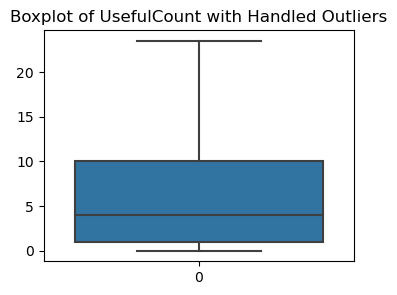

In [46]:
# Handle the outliers in the 'EaseofUse' column of the dataset by using flooring and capping:

data1['UsefulCount'] = np.where(data1['UsefulCount'] > up_lim, up_lim, np.where(data1['UsefulCount']<low_lim,low_lim,data1['UsefulCount']))
                                                                                                          
                                                                                                             
 # Again check for outliers after filling:

plt.figure(figsize=(4, 3))
sns.boxplot(data1['UsefulCount'])
plt.title('Boxplot of UsefulCount with Handled Outliers')
plt.show()

# Standard scaling

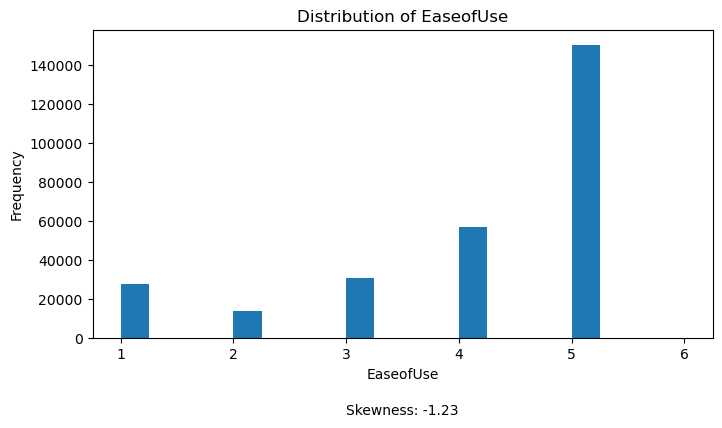

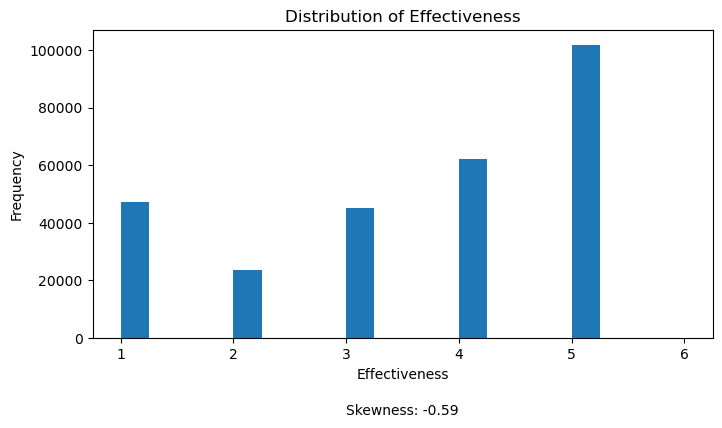

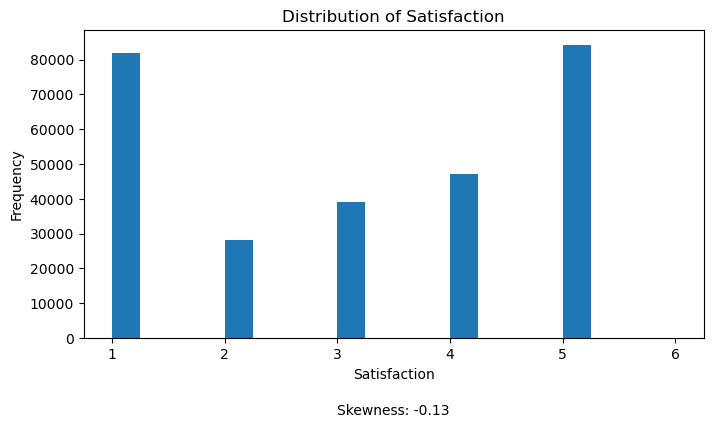

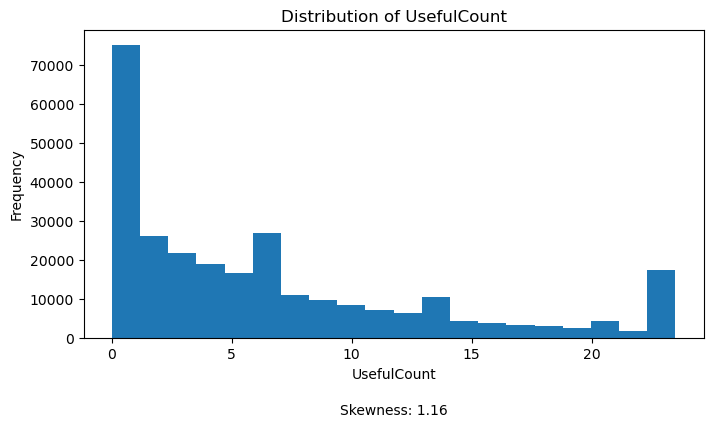

In [47]:
scaler = ['EaseofUse', 'Effectiveness', 'Satisfaction', 'UsefulCount']

for i in scaler:
    plt.figure(figsize=(8, 4))
    plt.hist(data1[i], bins=20)
    plt.title(f'Distribution of {i}')
    plt.xlabel(i)
    plt.ylabel('Frequency')
    
    skew = data1[i].skew()
    plt.text(.5, -.25, f"Skewness: {skew:.2f}", transform=plt.gca().transAxes, horizontalalignment='center')
    
    plt.show()

Inorder to remove the skewness in data standard scaling is performed in the UsefulCount and Ease of use  columns

-0.5680717873995585

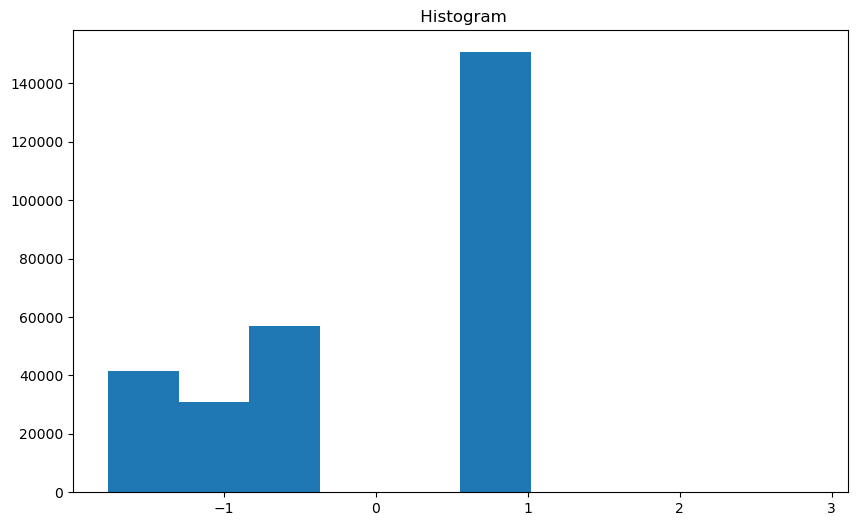

In [48]:
scaler = MinMaxScaler(feature_range=(1, 2))
power = PowerTransformer(method='box-cox')
pipeline = Pipeline(steps=[('s', scaler),('p', power)])

data_EaseofUse = pd.DataFrame(data1['EaseofUse'])
data_EaseofUse1 = pipeline.fit_transform(data_EaseofUse)

plt.figure(figsize=(10,6))
plt.hist(data_EaseofUse1)
plt.title(" Histogram")

data1['EaseofUse_boxcox'] = data_EaseofUse1
data1.EaseofUse_boxcox.skew()

0.21239077510398616

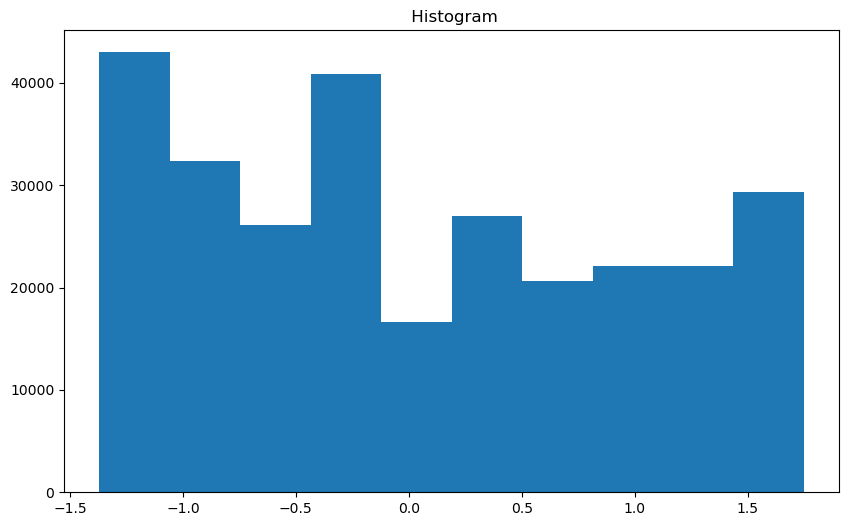

In [49]:
scaler = MinMaxScaler(feature_range=(1, 2))
power = PowerTransformer(method='box-cox')
pipeline = Pipeline(steps=[('s', scaler),('p', power)])

data_UsefulCount = pd.DataFrame(data1['UsefulCount'])
data_UsefulCount1 = pipeline.fit_transform(data_UsefulCount)

plt.figure(figsize=(10,6))
plt.hist(data_UsefulCount1)
plt.title(" Histogram")

data1['UsefulCount_boxcox'] = data_UsefulCount1
data1.UsefulCount_boxcox.skew()

# A drug named Cymbalta with DrugId 91491 is selected in building a classification model to determine side effects

In [94]:
data2 = data1[data1.DrugId == 91491]

# New Feature creation: SideEffects

In [51]:
mapping = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}
data2['SideEffects'] = data2['Satisfaction'].map(mapping)
# data2.loc[data2['Satisfaction'] == 1, 'Sideeffect'] = data2.loc[data2['Satisfaction'] == 1,5, 'Sideeffect']

In [52]:
data2.columns

Index(['Name', 'Race', 'Age', 'Condition', 'Date', 'Drug', 'DrugId',
       'EaseofUse', 'Effectiveness', 'Reviews', 'Satisfaction', 'Sex',
       'SideEffects', 'UsefulCount', 'Year', 'Month', 'day_of_week',
       'EaseofUse_boxcox', 'UsefulCount_boxcox'],
      dtype='object')

# EDA on Cymbalta

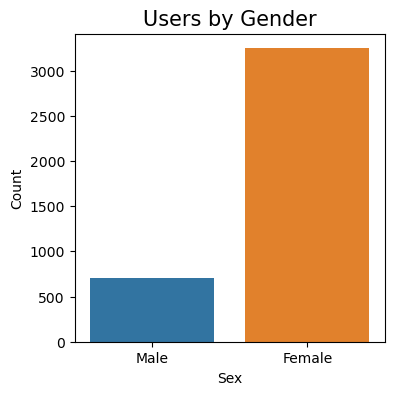

In [53]:
plt.figure(figsize = (4,4))
s=sns.countplot(x='Sex', data=data2)
plt.title('Users by Gender', fontsize=15)
plt.xlabel('Sex')
plt.ylabel('Count') 
plt.show()

Females are predominant users than males

Text(0, 0.5, 'Count')

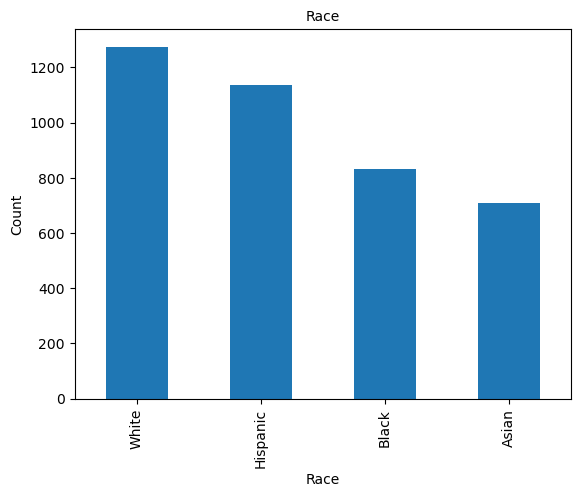

In [54]:
data2['Race'].value_counts().plot(kind='bar')
plt.title("Race", fontsize = 10)
plt.xlabel("Race", fontsize = 10)
plt.ylabel("Count", fontsize = 10)

White are predominant users.

Text(0.5, 1.0, 'Users by Race and Gender')

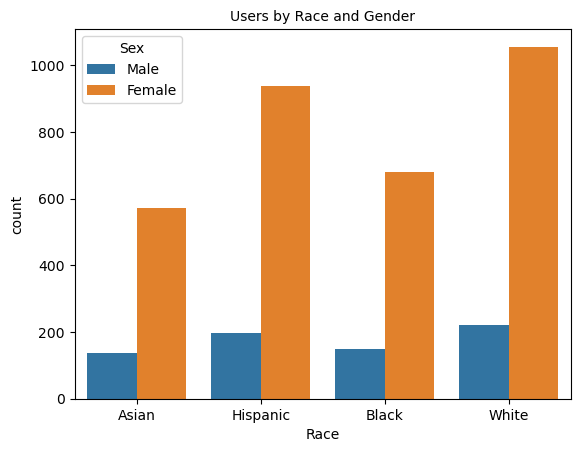

In [55]:
sns.countplot(x='Race',hue='Sex',data=data2)
plt.title("Users by Race and Gender", fontsize = 10)

As we can see females are predominant users in each race.

Text(0.5, 1.0, 'Users by Age and Gender')

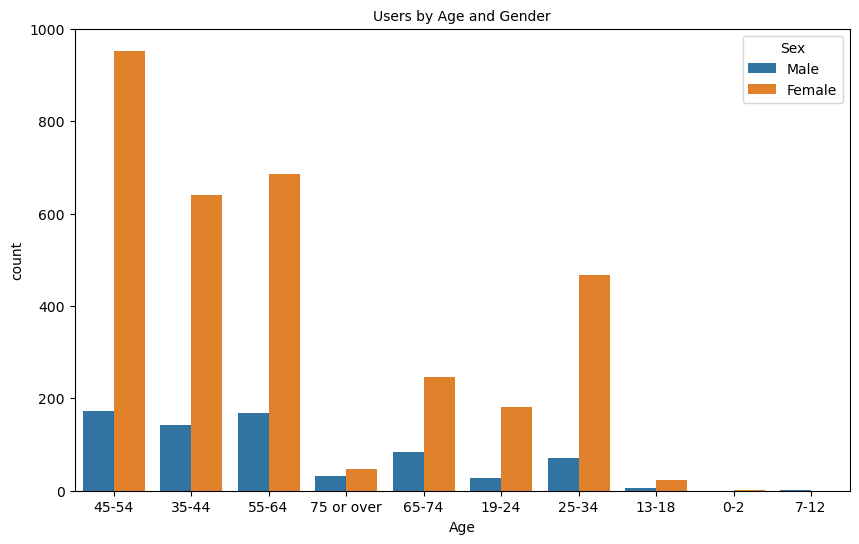

In [56]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Age',hue='Sex',data=data2)
plt.title("Users by Age and Gender", fontsize = 10)

In the graph, it is clear that in each age group females are predominant users.

Text(0, 0.5, 'Count of Reviews')

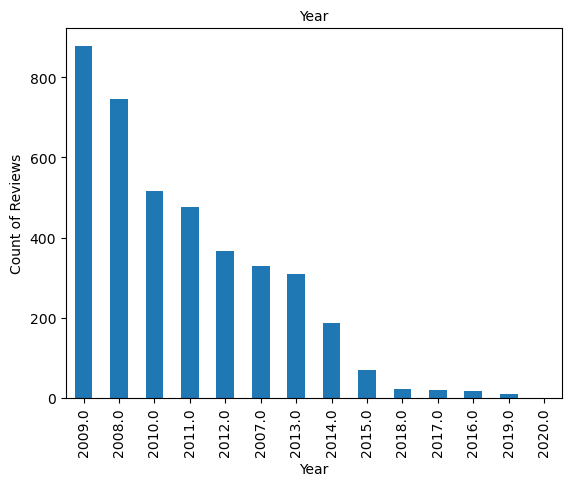

In [57]:
data2['Year'].value_counts().plot(kind='bar')
plt.title("Year", fontsize = 10)
plt.xlabel("Year", fontsize = 10)
plt.ylabel("Count of Reviews", fontsize = 10)

Maximum number of reviews came in the year 2009. There is a gradual decrease in the number of reviews in each year from the users.

Text(0, 0.5, 'Count')

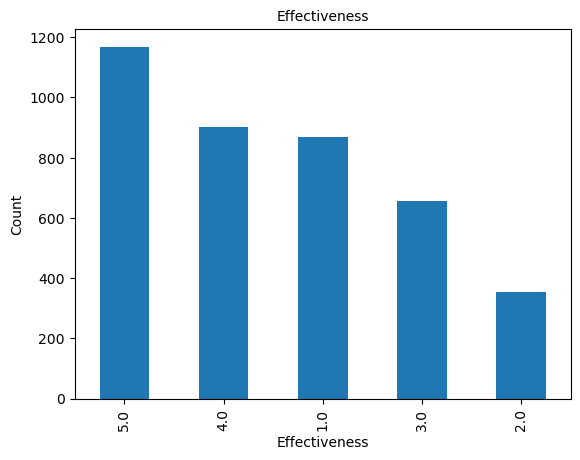

In [58]:
data2['Effectiveness'].value_counts().plot(kind='bar')
plt.title("Effectiveness", fontsize = 10)
plt.xlabel("Effectiveness", fontsize = 10)
plt.ylabel("Count", fontsize = 10)

The drug is effective for over 1000 people with a rating of 5

<Figure size 1000x800 with 0 Axes>

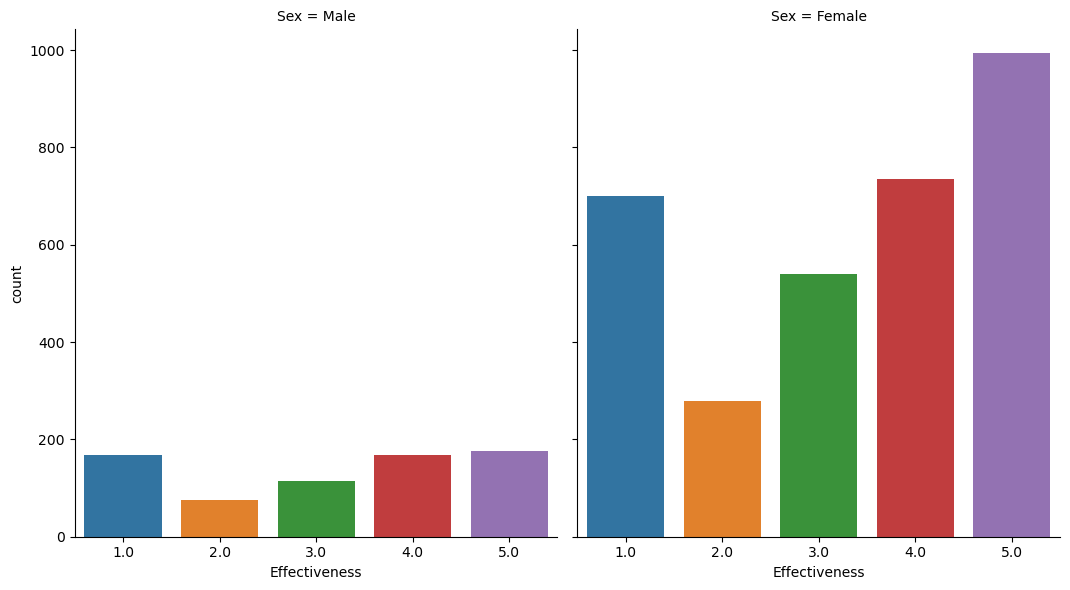

In [59]:
# Effectiveness vs sex
plt.figure(figsize=(10,8))
g = sns.catplot(x="Effectiveness",col="Sex",
                data=data2, kind="count",
                height=6,aspect =.9);

For males the drug was effective for more than 100 people with a rating of 4 and 5.
In the case of females the drug was effective for around 1000 people with a rating of 5.

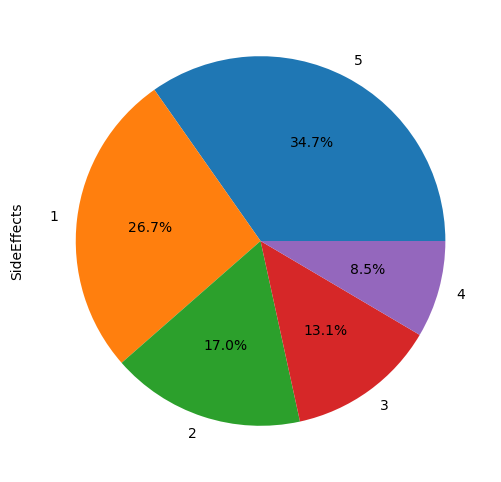

In [60]:
# Reported sideeffect of drug
plt.figure(figsize=(6,6))
data2['SideEffects'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

35% of people reported extreme sideeffect with 5 being the highest rating for extreme sideeffect and 1 for no sideeffect.

<Axes: xlabel='Age', ylabel='count'>

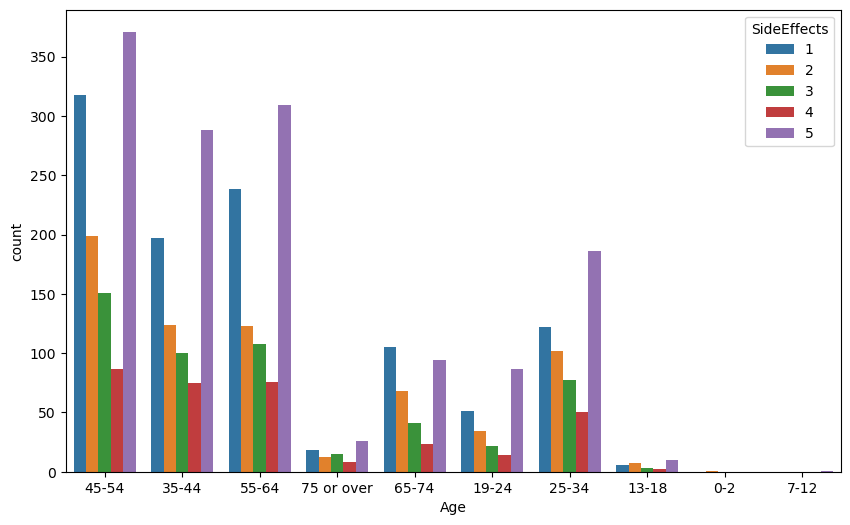

In [61]:
#Age vs sideeffects
plt.figure(figsize=(10, 6))
sns.countplot(x='Age',hue='SideEffects',data=data2)

#### 45-54 age group has opinionated that they had extreme side effects

<Figure size 2000x1000 with 0 Axes>

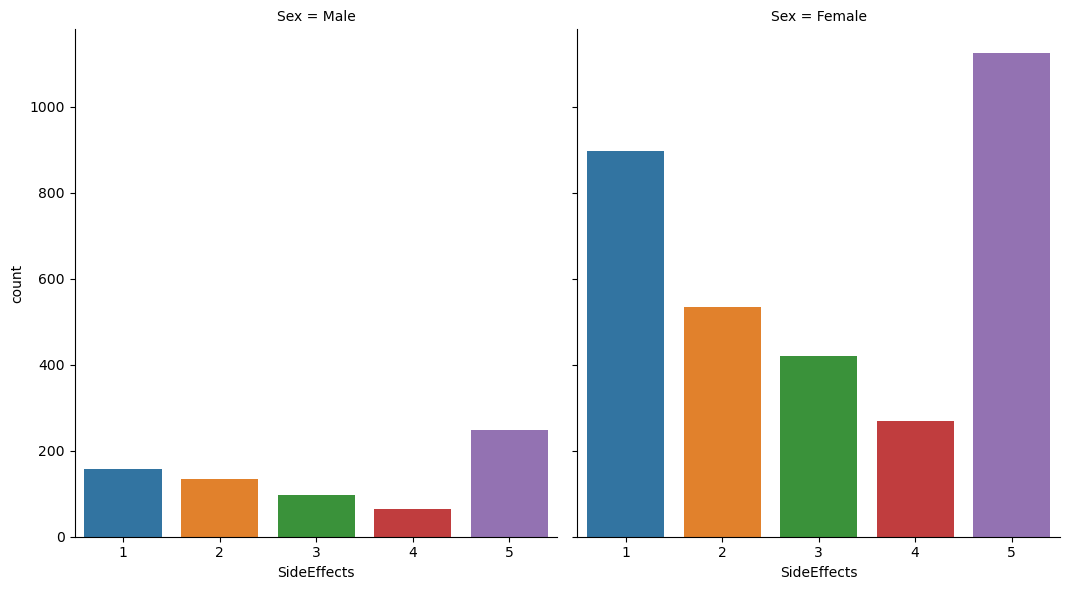

In [62]:
# Gender vs sideeffects
plt.figure(figsize=(20,10))

g = sns.catplot(x="SideEffects",col="Sex",data=data2, kind="count",height=6,aspect =.9);

Female users has more sideeffects compared to males

<Axes: xlabel='Race', ylabel='count'>

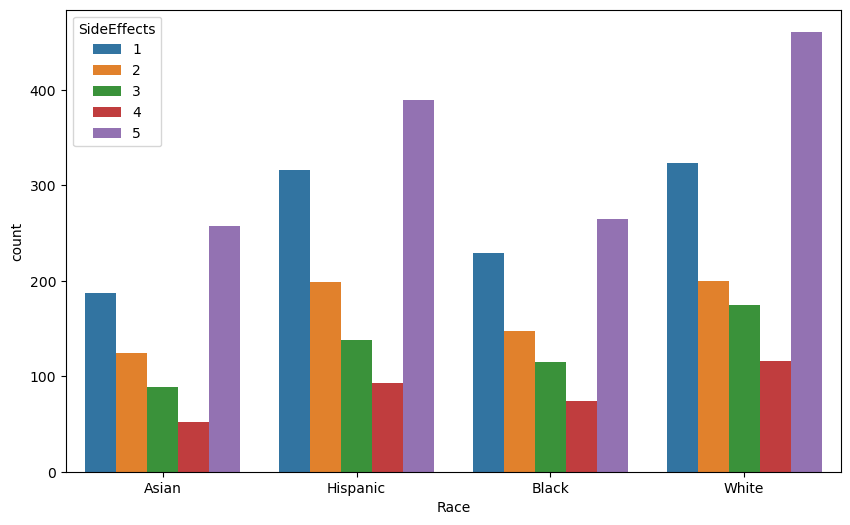

In [63]:
#Race vs Sideeffects
plt.figure(figsize=(10, 6))
sns.countplot(x='Race',hue='SideEffects',data=data2)

White and Hispanic has more sideeffects

# Reviews

In [64]:
data2.Reviews.sample(5)

316618    sTARTED WITH  30 mg FOR A LONG WHILE AND LATER...
318403    Experiencing extremely dry mouth.  I couldn't ...
316576    So far, so good. I am on my second week of the...
318170    I was taking Lyrica for nerve pain due to bein...
316469    i've been taking ritalin 5mg and xanax .5mg as...
Name: Reviews, dtype: object

#### Let us define a function to clean the text in the review so as to generate meaningfull output. The plan is to rank the reviews as either positive or negative. But, so as to rank the reviews, we need a more samples than what we have here. So, we will train the algoithm on the complete parent dataset (containing data about all the medicines). The algorithm will get trained on satisfaction and reviews, which means, it will identify which reviews or specifically word consitutes positive review ( satisfaction > 3) and which one consitute negative reviews (satisfaction < 3). Then, the generated model will be used to generate review rank ( 1 for positve and 0 for negative) for us in our dataset. Kindly note, the review rank for entries where satisfaction > 3 is 1 and for satisfaction < 3 is 0. The entries with satisfaction == 3 will be fed to the model to generate review rank values. Finally, our dataset will be complete after this.

# Cleaning the Global Review column

In [65]:
if data['Reviews'].dtype.kind == "O":
        data['Reviews'] = data['Reviews'].str.strip()

In [66]:
data['Reviews']= data['Reviews'].astype(str)

In [67]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords

In [68]:
import spacy
import string
import pandas as pd
from multiprocessing import Pool
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words

def preprocess_text(text, STOPWORDS, nlp):
    """Cleans up text"""
    # Your text preprocessing functions here...

def preprocess_data(data, batch_size=1000, num_processes=4):
    # Load spaCy model
    nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

    # Define constants
    STOPWORDS = set(sklearn_stop_words).union(set(stopwords.words("english")))

    preprocessed_data_list = []

    for i in range(0, len(data), batch_size):
        data_batch = data[i:i + batch_size]

        with Pool(processes=num_processes) as pool:
            processed_batch = pool.map(preprocess_text, data_batch["Reviews"], STOPWORDS, nlp)

        preprocessed_data_list.extend(processed_batch)

    preprocessed_data = pd.DataFrame({"Preprocessed_Reviews": preprocessed_data_list})

    mldf = pd.concat([data[["Satisfaction"]], preprocessed_data], axis=1)
    mldf["Preprocessed_Reviews"].replace("", np.nan, inplace=True)
    mldf.dropna(inplace=True)
    mldf.reset_index(inplace=True, drop=True)

    return mldf


#### Review column is cleaned. A new column satisfaction1 is generated which will help in identifiying postive and negative reviews for algorithm where 0 is negative, 2 is positive and 1 is neutral for satisfaction < 3, > 3 and ==3 respectively. We will omit the neutral reviews.

In [72]:
mldf = data[["Satisfaction", "Reviews"]]
def relabel(x):
    return 0 if x < 3 else 1 if x == 3 else 2

mldf["Satisfaction1"] = mldf["Satisfaction"].apply(relabel)

# Generating Text processing Model

In [74]:
train_set, test_set = train_test_split(mldf, test_size=0.25, random_state=0, stratify=mldf["Satisfaction1"])
train_index = train_set.index
test_index = test_set.index
print(train_set.shape)
print(test_set.shape)

(272104, 3)
(90702, 3)


In [75]:
# Filter out rows with "Satisfaction1" equal to 1
train_set = train_set[train_set["Satisfaction1"] != 1]
test_set = test_set[test_set["Satisfaction1"] != 1]

In [76]:
# Define vectorizer
vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)

# Vectorize the text data
X_train = vectorizer.fit_transform(train_set["Reviews"])
X_test = vectorizer.transform(test_set["Reviews"])
y_train = train_set["Satisfaction1"].values
y_test = test_set["Satisfaction1"].values

In [77]:
# Define and train the Random Forest model
model = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=0, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=50, n_jobs=-1,
                       random_state=0)

In [78]:
# Evaluate the model
acc_train = accuracy_score(y_train, model.predict(X_train))
print(f"Accuracy on the training set: {acc_train:.2f}")

predictions = model.predict(X_test)
acc_test = accuracy_score(y_test, predictions)
print(f"Accuracy on the test set: {acc_test:.2f}")
print(classification_report(y_test, predictions))

Accuracy on the training set: 0.97
Accuracy on the test set: 0.84
              precision    recall  f1-score   support

           0       0.85      0.77      0.81     34061
           2       0.83      0.90      0.86     43678

    accuracy                           0.84     77739
   macro avg       0.84      0.83      0.84     77739
weighted avg       0.84      0.84      0.84     77739



#### Let us the clean the review specific to our drug

In [81]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
STOPWORDS = set(sklearn_stop_words).union(set(stopwords.words("english")))

def clean_review(text, STOPWORDS=STOPWORDS, nlp=nlp):
    """Cleans up text"""
    
    def rep_emo(text, placeholder_pos=' happyemoticon ', placeholder_neg=' sademoticon '):
        """Replace emoticons"""
        # Credit https://github.com/shaheen-syed/Twitter-Sentiment-Analysis/blob/master/helper_functions.py
        emoticons_pos = [":)", ":-)", ":p", ":-p", ":P", ":-P", ":D",":-D", ":]", ":-]", ";)", ";-)",
                         ";p", ";-p", ";P", ";-P", ";D", ";-D", ";]", ";-]", "=)", "=-)", "<3"]
        emoticons_neg = [":o", ":-o", ":O", ":-O", ":(", ":-(", ":c", ":-c", ":C", ":-C", ":[", ":-[",
                         ":/", ":-/", ":\\", ":-\\", ":n", ":-n", ":u", ":-u", "=(", "=-(", ":$", ":-$"]

        for e in emoticons_pos:
            text = text.replace(e, placeholder_pos)

        for e in emoticons_neg:
            text = text.replace(e, placeholder_neg)   
        return text

    def rep_punct(text):
        """Replace all punctuation with space"""
        for c in string.punctuation:
            text = text.replace(c, " ")
        return text

    def rem_stop_num(text):
        """Remove stop words and anything starting with number"""
        return " ".join(word for word in text.split() if word not in STOPWORDS and not word[0].isdigit())

    def lemmatize(text):
        """Return lemmas of tokens in text"""
        return " ".join(tok.lemma_.lower().strip() for tok in nlp(text) if tok.lemma_ != "-PRON-")  

    return lemmatize(rem_stop_num(rep_punct(rep_emo(text))))

In [82]:
data2["Reviews"] = data2["Reviews"].apply(clean_review)

# Let us the rank the reviews by creating a function for the same

In [83]:
def predict_rank(text):
    cleaned_text = [clean_review(text)]
    padded_text = vectorizer.transform(cleaned_text)
    p = model.predict(padded_text)[0]
    if (p == 0):
        return 0
    else :
        return 1
    
def predict_rank1(rank):
    if (rank < 3):
        return 0
    else:
        return 1
    
# predict_rank("I loved it")
data2['Reviews_Rank'] = data2['Satisfaction']
data2.loc[data2['Satisfaction'] < 3, 'Reviews_Rank'] = data2.loc[data2['Satisfaction'] < 3, 'Reviews_Rank'].apply(predict_rank1)
data2.loc[data2['Satisfaction'] > 3, 'Reviews_Rank'] = data2.loc[data2['Satisfaction'] > 3, 'Reviews_Rank'].apply(predict_rank1)
data2.loc[data2['Satisfaction'] == 3, 'Reviews_Rank'] = data2.loc[data2['Satisfaction'] == 3, 'Reviews'].apply(predict_rank)
data2['Reviews_Rank'].unique()

array([0., 1.])

#### Columns Name has unique values so will be dropped. Drug, DrugId, Condition, Date, Easeofuse, usefulcount, sides, Year will be dropped. Race, Sex, Year, Month, Dayofweek will be onehot encoded. Satisfaction will be segregated based on the values as nil, mild, moderate, sever, extreme based on values of 5, 4, 3, 2, 1 respectively. The assumption being that thet satisfaction is a parameter that gets affected by side effects in case of patients.

In [100]:
data2.drop(['Name','Condition','Date','Drug','DrugId','EaseofUse','SideEffects','UsefulCount'], axis=1, inplace = True)

KeyError: "['Name', 'Condition', 'Date', 'Drug', 'DrugId', 'EaseofUse', 'UsefulCount'] not found in axis"

In [96]:
data2.Month = data2.Month.astype(str)
data2.Year = data2.Year.astype(str)
data_encod = data2[['Race', 'Age','Sex','Month','day_of_week']]
data_num = data2[['Effectiveness']]
data2.columns

Index(['Race', 'Age', 'Effectiveness', 'Reviews', 'Satisfaction', 'Sex',
       'SideEffects', 'Year', 'Month', 'day_of_week', 'EaseofUse_boxcox',
       'UsefulCount_boxcox'],
      dtype='object')

# Encoding : One Hot Encoding

In [86]:
data_encod = pd.get_dummies(data_encod)
data_encod

,Race_Asian,Race_Black,Race_Hispanic,Race_White,Age_0-2,Age_13-18,Age_19-24,Age_25-34,Age_35-44,Age_45-54,...,Month_7.0,Month_8.0,Month_9.0,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
314216,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
314235,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
314267,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
314305,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
314323,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319080,0,0,0,1,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
319081,0,0,1,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
319082,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
319084,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


# Scaling : Standard Scaling

In [87]:
from sklearn.preprocessing import StandardScaler
mm = StandardScaler()
data_num = mm.fit_transform(data_num)
data_num = pd.DataFrame(data_num, columns = ['Effectiveness'])
data_num

,Effectiveness
0,-1.512045
1,-0.192327
2,0.467533
3,0.467533
4,1.127392
...,...
3944,-1.512045
3945,1.127392
3946,-0.192327
3947,0.467533


In [88]:
data3 = data_encod
data3['Effectiveness'] = data_num.values
data3

,Race_Asian,Race_Black,Race_Hispanic,Race_White,Age_0-2,Age_13-18,Age_19-24,Age_25-34,Age_35-44,Age_45-54,...,Month_8.0,Month_9.0,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,Effectiveness
314216,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,-1.512045
314235,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,-0.192327
314267,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0.467533
314305,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0.467533
314323,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1.127392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319080,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,-1.512045
319081,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1.127392
319082,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,-0.192327
319084,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.467533


#### So finally what I suppose is the following features which are race, age, review rank and effectiveness can form the dataset which will predict the sideeffect of the user.

In [89]:
data3 = data_encod
data3['Effectiveness'] = data_num.values
data3['UsefulCount_boxcox'] = data2['UsefulCount_boxcox']
data3['EaseofUse_boxcox'] = data2['EaseofUse_boxcox' ]
data3

,Race_Asian,Race_Black,Race_Hispanic,Race_White,Age_0-2,Age_13-18,Age_19-24,Age_25-34,Age_35-44,Age_45-54,...,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,Effectiveness,UsefulCount_boxcox,EaseofUse_boxcox
314216,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,-1.512045,-1.369984,-1.150033
314235,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,-0.192327,-1.369984,-1.150033
314267,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0.467533,-1.369984,0.856565
314305,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.467533,-1.369984,0.856565
314323,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1.127392,-1.003508,0.856565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319080,0,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,-1.512045,1.140812,0.856565
319081,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1.127392,0.249039,0.856565
319082,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,-0.192327,0.711377,0.856565
319084,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.467533,0.249039,-0.405723


# data3 forms our final dataset

In [105]:
data4 = pd.DataFrame (data1['SideEffects'])
data4

,SideEffects
0,"Drowsiness, dizziness , dry mouth /nose/thro..."
1,"Drowsiness, dizziness , dry mouth /nose/thro..."
6,"Nausea , vomiting , headache , bloating , ..."
7,"Nausea , vomiting , headache , bloating , ..."
9,"Temporary burning, stinging, dryness in the no..."
...,...
362799,"Nausea , headache , vomiting , drowsiness, g..."
362801,"Nausea , headache , vomiting , drowsiness, g..."
362803,"Nausea , headache , vomiting , drowsiness, g..."
362804,"Nausea , headache , vomiting , drowsiness, g..."


# data4 forms target

In [106]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data3,data4,test_size=0.25, random_state = 42, stratify=data4)

ValueError: Found input variables with inconsistent numbers of samples: [3949, 280127]

# Log Regression

In [99]:
#log regression
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression()
# solver='lbfgs',max_iter=10000
model1 = log_reg.fit(X_train,Y_train)
Y_pred_logreg = model1.predict(X_test)

#metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
print(confusion_matrix(Y_test,Y_pred_logreg))
print("LogisticRegression accuracy score is:",accuracy_score(Y_test,Y_pred_logreg))

#CLassification Report
from sklearn.metrics import classification_report
report = classification_report(Y_test,Y_pred_logreg)
print(report)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'Nausea ,  dry mouth ,  constipation , loss of appetite, tiredness, drowsiness, or increased  sweating  may occur.'

# SVM Polynomial

In [104]:
#SVM polynomial
from sklearn.svm import SVC
svm_clf_p = SVC(kernel='poly', degree = 4, probability=True)
svm_model = svm_clf_p.fit(X_train, Y_train)
y_pred_svmp = svm_clf_p.predict(X_test)
# metrics
print(confusion_matrix(Y_test, y_pred_svmp))
print("SVM polynomial accuracy score is:",accuracy_score(Y_test, y_pred_svmp))

#CLassification Report
from sklearn.metrics import classification_report
report = classification_report(Y_test,y_pred_svmp)
print(report)

ValueError: The number of classes has to be greater than one; got 1 class

# SVM RBF

In [ ]:
#svm rbf
from sklearn.svm import SVC
svm_clf_r = SVC(kernel='rbf', degree = 4, probability=True)
svm_model = svm_clf_r.fit(X_train, Y_train)
y_pred_svmr = svm_clf_r.predict(X_test)
# metrics
print(confusion_matrix(Y_test, y_pred_svmr))
print("SVM RBF accuracy score is:",accuracy_score(Y_test, y_pred_svmr))

#CLassification Report
from sklearn.metrics import classification_report
report = classification_report(Y_test,y_pred_svmr)
print(report)


# kNN

In [ ]:
#knn
from sklearn.neighbors import KNeighborsClassifier
metric_k = []
neighbours = np.arange(3,15)

for k in neighbours:
        knn = KNeighborsClassifier(n_neighbors=k)
        model2 = knn.fit(X_train, Y_train)
        Y_pred_knn = model2.predict(X_test)
        acc=accuracy_score(Y_test,Y_pred_knn)
        metric_k.append(acc)
        
plt.plot(neighbours,metric_k,'*-')
plt.xlabel('k value')
plt.ylabel('accuracy')
plt.grid()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11)
model2 = knn.fit(X_train, Y_train)
Y_pred_knn = model2.predict(X_test)
# metrics
print(confusion_matrix(Y_test,Y_pred_knn))
print("KNN accuracy score is:",accuracy_score(Y_test,Y_pred_knn))


#CLassification Report
from sklearn.metrics import classification_report
report = classification_report(Y_test,Y_pred_knn)
print(report)

# Decision Tree

In [ ]:
#decision tree
from sklearn.tree import DecisionTreeClassifier
dtm_clf = DecisionTreeClassifier(random_state = 42)
dtm_clf.fit(X_train, Y_train)
y_pred_dtm = dtm_clf.predict(X_test)
# metrics
print(confusion_matrix(Y_test, y_pred_dtm))
print("DecisionTreeClassifier accuracy score is:",accuracy_score(Y_test, y_pred_dtm))

#CLassification Report
from sklearn.metrics import classification_report
report = classification_report(Y_test,y_pred_dtm)
print(report)

# Random forest

In [ ]:
#random forest model
from sklearn.ensemble import RandomForestClassifier
rfm_clf = RandomForestClassifier(random_state = 42)
rfm_clf.fit(X_train, Y_train)
y_pred_rfm = rfm_clf.predict(X_test)
# metrics
print(confusion_matrix(Y_test, y_pred_rfm))
print("random forest accuracy score is:",accuracy_score(Y_test, y_pred_rfm))


#CLassification Report
from sklearn.metrics import classification_report
report = classification_report(Y_test,y_pred_rfm)
print(report)

# Ridge Classifier

In [ ]:
from sklearn.linear_model import RidgeClassifier
rid_clf = RidgeClassifier()
rid_clf.fit(X_train, Y_train)
y_pred_rid = rid_clf.predict(X_test)
# metrics
print(confusion_matrix(Y_test, y_pred_rid))
print("RidgeClassifier accuracy score is:",accuracy_score(Y_test, y_pred_rid))


#CLassification Report
from sklearn.metrics import classification_report
report = classification_report(Y_test,y_pred_rid)
print(report)

# Bagging Classifier

In [ ]:
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier()
bag_clf.fit(X_train, Y_train)
y_pred_bag = bag_clf.predict(X_test)
# metrics
print(confusion_matrix(Y_test, y_pred_bag))
print("BaggingClassifier accuracy score is:",accuracy_score(Y_test, y_pred_bag))


#CLassification Report
from sklearn.metrics import classification_report
report = classification_report(Y_test,y_pred_bag)
print(report)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
grd_clf = GradientBoostingClassifier()
grd_clf.fit(X_train, Y_train)
y_pred_grd = grd_clf.predict(X_test)
# metrics
print(confusion_matrix(Y_test, y_pred_grd))
print(accuracy_score(Y_test, y_pred_grd))


#CLassification Report
from sklearn.metrics import classification_report
report = classification_report(Y_test,y_pred_grd)
print(report)

# HyperTuning Parameters

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [1, 10, 100], 'criterion': ['gini', 'entropy'], 'min_samples_leaf' : list(range(25, 100)), 'min_samples_split': [2, 3, 4], 'max_features': ['auto','log2']}
rfc_tuned = RandomForestClassifier()
model_tuning_RF = GridSearchCV(rfc_tuned, param_grid=params, verbose=1, cv=3, scoring = 'recall')
grid_rf_metrics = model_tuning_RF.fit(X_train, Y_train)

In [ ]:
print("Best: %f using %s" % (grid_rf_metrics.best_score_, grid_rf_metrics.best_params_))

In [ ]:
y_pred_rfm = model_tuning_RF.predict(X_test)
# metrics
print(confusion_matrix(Y_test, y_pred_rfm))
print(accuracy_score(Y_test, y_pred_rfm))


#CLassification Report
from sklearn.metrics import classification_report
report = classification_report(Y_test,y_pred_rfm)
print(report)

#### Analysis Result:
#### Accuracy Values of each algorithm:
#### Logarithmic Regression: 71%
#### SVM Polynomial: 74%
#### SVM RBF: 72%
#### Decision Tree: 65%
#### kNN :  65%
#### Ridge : 59%
#### Bagging Classifier : 82%
#### GradientBoostingClassifier :  72%
#### Random Forest Classifier gave an accuracy of 60%. 
Hence, Bagging classifier model is selected